### 0. Feature Engineering 

1. Node-based features
Importance-based features
1.1. Node degree
1.2. Node centrality
1.2.1. Eigenvector centrality
1.2.2. Betweenness centrality
1.2.3. Closeness centrality
Structure-based features
1.1. Node degree
1.2. Clustering coefficient
1.3. Graphlets (cach tinh graphlet)
2. Edge-based features
2.1. Distance-based features: shortest-path distance between 2 nodes
2.2. Local neighborhood overlap feature: common neighbors, Jaccard's coefficient. Adamic-Adar
2.3. Global neighborhood overlap feature: Katz index (cach tinh Katz index)

Trong sample code, RolX algorithm, learning local and global consistency (Harmonic Function), Label propagation, Node features, Node centrality (eigenvector, betweenness, closeness, clustering coefficient)

Edge-level features: distance based feature
Shortest path
Local Neighborhood Overlap - Jaccard Coefficient
Global Neighborhood Overlap - Katz index


# 0. Review feature engineering

In [1]:
import networkx as nx

# Create a sample graph
G = nx.Graph()
G.add_edges_from([(1, 2), (1, 3), (2, 3), (2, 4), (3, 4)])

# Node-based features
# 1.1 Node degree
node_degree = dict(G.degree())

# 1.2 Node centrality
# 1.2.1 Eigenvector centrality
node_eigenvector_centrality = nx.eigenvector_centrality(G)

# 1.2.2 Betweenness centrality
node_betweenness_centrality = nx.betweenness_centrality(G)

# 1.2.3 Closeness centrality
node_closeness_centrality = nx.closeness_centrality(G)

# Structure-based features

# 1.1 Clustering coefficient
node_clustering_coefficient = nx.clustering(G)

# Edge-based features
# 2.1 Distance-based features: shortest-path distance between 2 nodes
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

# 2.2 Local neighborhood overlap feature: common neighbors, Jaccard's coefficient, Adamic-Adar
common_neighbors = nx.common_neighbors(G, 1, 2)
jaccard_coefficient = nx.jaccard_coefficient(G, [(1, 2)])
adamic_adar_index = nx.adamic_adar_index(G, [(1, 2)])

# 2.3 Global neighborhood overlap feature: Katz index 
def katz_index(graph, alpha, beta):
    n = graph.number_of_nodes()
    adj_matrix = nx.adjacency_matrix(graph).todense()
    eigenvalues = max(abs(e) for e in nx.adjacency_spectrum(graph))
    katz_matrix = (beta / eigenvalues) * adj_matrix
    katz_matrix += alpha * nx.adjacency_matrix(graph).todense()
    katz_scores = nx.pagerank(nx.from_numpy_array(katz_matrix))
    return katz_scores

katz_scores = katz_index(G, alpha=0.1, beta=0.5)

# Print the features
print("Node degree:", node_degree)
print("Node eigenvector centrality:", node_eigenvector_centrality)
print("Node betweenness centrality:", node_betweenness_centrality)
print("Node closeness centrality:", node_closeness_centrality)
print("Node clustering coefficient:", node_clustering_coefficient)
print("Shortest path lengths:", shortest_path_lengths)
print("Common neighbors:", list(common_neighbors))
print("Jaccard coefficient:", list(jaccard_coefficient))
print("Adamic-Adar index:", list(adamic_adar_index))
print("Katz index:", katz_scores)

Node degree: {1: 2, 2: 3, 3: 3, 4: 2}
Node eigenvector centrality: {1: 0.43516217270028296, 2: 0.5573453897277424, 3: 0.5573453897277424, 4: 0.43516217270028296}
Node betweenness centrality: {1: 0.0, 2: 0.16666666666666666, 3: 0.16666666666666666, 4: 0.0}
Node closeness centrality: {1: 0.75, 2: 1.0, 3: 1.0, 4: 0.75}
Node clustering coefficient: {1: 1.0, 2: 0.6666666666666666, 3: 0.6666666666666666, 4: 1.0}
Shortest path lengths: {1: {1: 0, 2: 1, 3: 1, 4: 2}, 2: {2: 0, 1: 1, 3: 1, 4: 1}, 3: {3: 0, 1: 1, 2: 1, 4: 1}, 4: {4: 0, 2: 1, 3: 1, 1: 2}}
Common neighbors: [3]
Jaccard coefficient: [(1, 2, 0.25)]
Adamic-Adar index: [(1, 2, 0.9102392266268373)]
Katz index: {0: 0.20478693540661064, 1: 0.29521306459338925, 2: 0.29521306459338925, 3: 0.20478693540661064}


# 2. SimRank based method to find node label

Idea:  Two objects are similar if they are referenced by similar objects.

Intuition: Two objects are similar, if they are related to similar objects
Two objects x and y are similar, 

if they are related to objects a and b respectively and a and b are themselves similar.


Task: Given a graph G with seven nodes (0,1,2,3,4,5,6) with different labels.
Finding the label of nodeID '4' based on SimRank.

The label of node '4' should be the same label of the node that have highest Simrank similarity.


In [21]:
# import libraries

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


In [22]:
# Instantiate the graph
G = nx.Graph()
# Add node/edge pairs
G.add_edges_from([ (0, 1),
                   (0, 2),
                   (0, 3),
                   (0, 5),
                   (0, 6),
                   (1, 3),
                   (1, 6),
                   (3, 4),
                   (4, 5)])

In [23]:
#check graph properties
print("# Nodes: ", int(G.number_of_nodes()))
print("# Edges: ", int(G.number_of_edges()))
print("List of nodes: ", list(G.nodes()))
print("List of edges: ", list(G.edges(data = True)))

# Nodes:  7
# Edges:  9
List of nodes:  [0, 1, 2, 3, 5, 6, 4]
List of edges:  [(0, 1, {}), (0, 2, {}), (0, 3, {}), (0, 5, {}), (0, 6, {}), (1, 3, {}), (1, 6, {}), (3, 4, {}), (5, 4, {})]


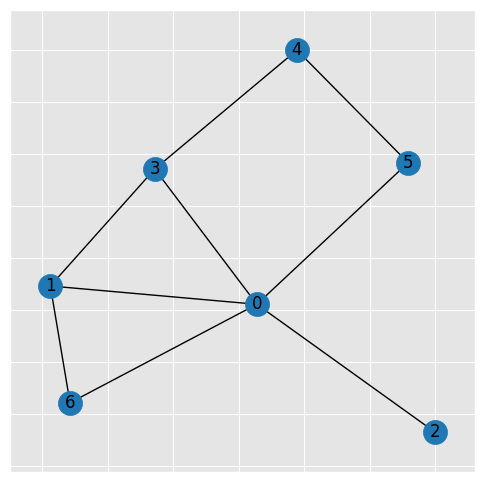

In [24]:
# draw the network G
plt.figure(figsize =(6, 6))
nx.draw_networkx(G, with_labels = True)

In [25]:
#Draw graphs with different labeled nodes
def draw_graph(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['label']
        col = 0
        if c=='A':
            clubs.append('green')
        elif c =='B':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph

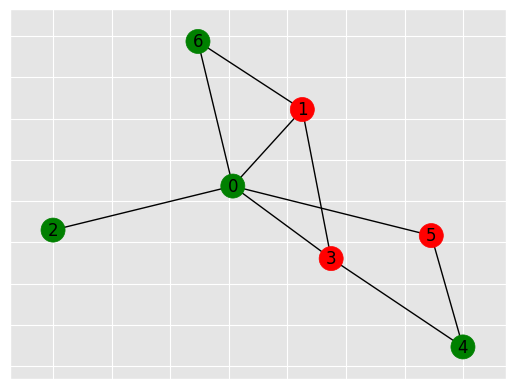

In [26]:
#fill labels in graph G
def fill_labels(G):
    for i in range(len(G.nodes)):
        if i%2 ==0:
            G.nodes[i]['label'] = 'A'
        else:
            G.nodes[i]['label'] = 'B'
mapping = {}
for i in G.nodes:
    mapping[f"{i}"] = int(i)
G = nx.relabel_nodes(G, mapping)

fill_labels(G)
draw_graph(G)

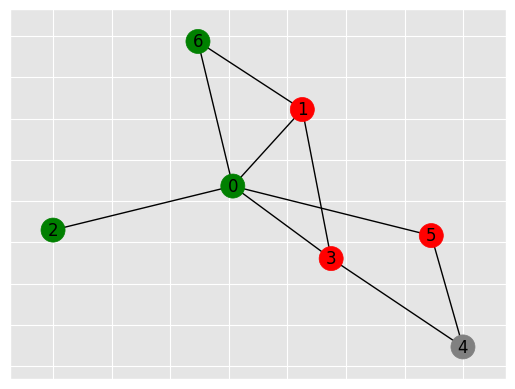

In [27]:
# Lets hide labels of node 4
unlabel_set = [4]
for n in unlabel_set:
    G.nodes[n]['label'] = ''
draw_graph(G)

In [28]:
# Get Simrank similarity for node 4
simrank = nx.simrank_similarity(G, source=4)
simrank
del simrank[4]

In [71]:
simrank

{0: 0.6265517591539647,
 1: 0.565258847527323,
 2: 0.38221826952362126,
 3: 0.389897094467832,
 5: 0.3597408540092107,
 6: 0.416213922454348}

In [30]:
#finding the nodeID that have highest Simrank.
max_nodeID_similar = max(simrank, key=lambda k: simrank[k])
max_nodeID_similar


0

In [31]:
G.nodes[4]['label'] = G.nodes[0]['label']

In [32]:
G.nodes[4]['label']

'A'

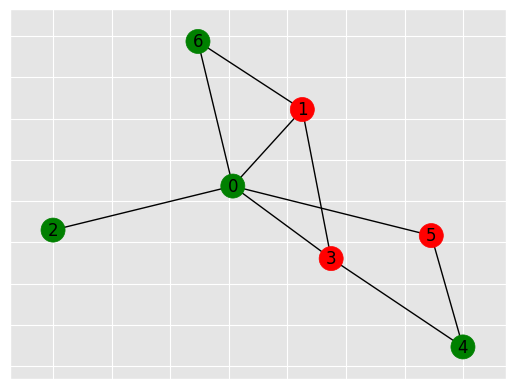

In [33]:
draw_graph(G)

# 3. Rolx algorithm
Feature Extraction : external_edges(mean), degree(mean),  degree(sum), internal_edges

Classifiers:  logistic regression

In [34]:
#import necessary libraries
# !pip install graphrole

import warnings
from pprint import pprint

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from graphrole import RecursiveFeatureExtractor, RoleExtractor

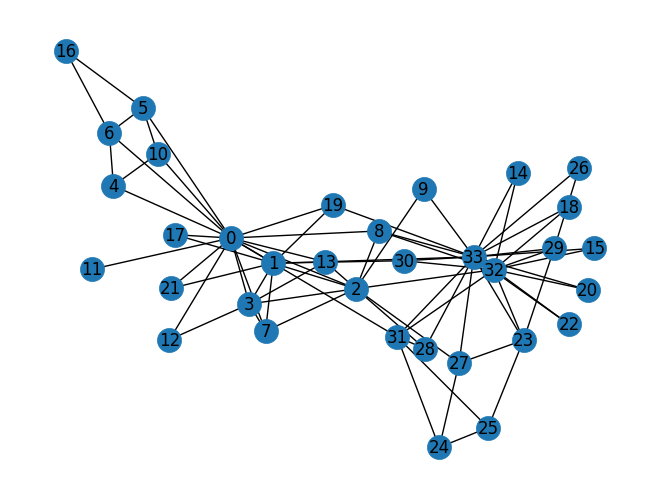

In [73]:
#Load graph data from edgelist file
G = nx.read_edgelist('./data/karate_edgelist.txt')
nx.draw(G, with_labels = True)

plt.show()

In [74]:
# extract features from 1 recursive generations:
feature_extractor = RecursiveFeatureExtractor(G)
features = feature_extractor.extract_features()

print(f'Features extracted from {feature_extractor.generation_count} recursive generations:')
print(features)

Features extracted from 3 recursive generations:
    external_edges(mean)(mean)  degree(mean)  degree(sum)  \
0                    19.001736      4.250000         68.0   
1                    21.199074      5.666667         51.0   
10                   17.763889      7.666667         23.0   
11                   24.875000     16.000000         16.0   
12                   25.020833     11.000000         22.0   
13                   26.732516     11.600000         58.0   
14                   29.046569     14.500000         29.0   
15                   29.046569     14.500000         29.0   
16                   12.750000      4.000000          8.0   
17                   26.159722     12.500000         25.0   
18                   29.046569     14.500000         29.0   
19                   27.165305     14.000000         42.0   
2                    24.965278      6.500000         65.0   
20                   29.046569     14.500000         29.0   
21                   26.159722     1

In [37]:
# assign node roles
role_extractor = RoleExtractor(n_roles=None)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles

print('\nNode role assignments:')
pprint(node_roles)

print('\nNode role membership by percentage:')
print(role_extractor.role_percentage.round(2))


Node role assignments:
{'0': 'role_3',
 '1': 'role_6',
 '10': 'role_1',
 '11': 'role_1',
 '12': 'role_1',
 '13': 'role_2',
 '14': 'role_1',
 '15': 'role_1',
 '16': 'role_1',
 '17': 'role_1',
 '18': 'role_1',
 '19': 'role_2',
 '2': 'role_6',
 '20': 'role_1',
 '21': 'role_1',
 '22': 'role_1',
 '23': 'role_6',
 '24': 'role_1',
 '25': 'role_1',
 '26': 'role_1',
 '27': 'role_2',
 '28': 'role_1',
 '29': 'role_0',
 '3': 'role_5',
 '30': 'role_1',
 '31': 'role_2',
 '32': 'role_6',
 '33': 'role_3',
 '4': 'role_1',
 '5': 'role_4',
 '6': 'role_4',
 '7': 'role_1',
 '8': 'role_2',
 '9': 'role_1'}

Node role membership by percentage:
    role_0  role_1  role_2  role_3  role_4  role_5  role_6
0     0.05    0.01    0.01    0.55    0.01    0.01    0.37
1     0.12    0.01    0.01    0.01    0.01    0.38    0.47
10    0.11    0.39    0.11    0.11    0.01    0.01    0.25
11    0.01    0.74    0.01    0.10    0.01    0.10    0.01
12    0.10    0.48    0.01    0.01    0.10    0.21    0.10
13    0.04    0.0

In [38]:
# Build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
color_map = sns.color_palette('Paired', n_colors = len(unique_roles))
# Map roles to colors
role_colors = {role: color_map[i] for i, role in enumerate(unique_roles)}
# Build list of colors for all nodes in G
node_colors = [role_colors[node_roles[node]] for node in G.nodes]

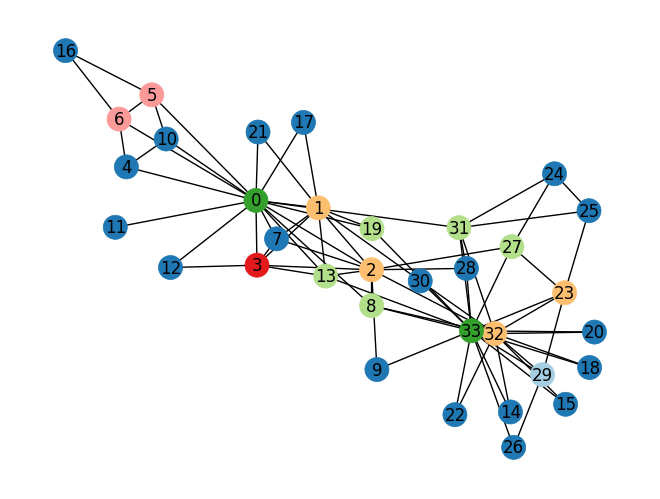

In [39]:
# plot graph
plt.figure()

with warnings.catch_warnings():
    # catch matplotlib deprecation warning
    warnings.simplefilter('ignore')
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=node_colors,
    )

plt.show()


# 4. Learning with Local and Global Consistency
(Zhou, Dengyong, Olivier Bousquet, Thomas Lal, Jason Weston, and Bernhard Schölkopf. "Learning with local and global consistency. " Advances in neural information processing systems 16 (2003).)

The keynote of method is to let every point iteratively spread its label information to its neighbours until a global stable state is achieved

## Testing small graph

In [40]:
#Draw graphs with different labeled nodes
def draw_graph(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['label']
        col = 0
        if c=='A':
            clubs.append('green')
        elif c =='B':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph

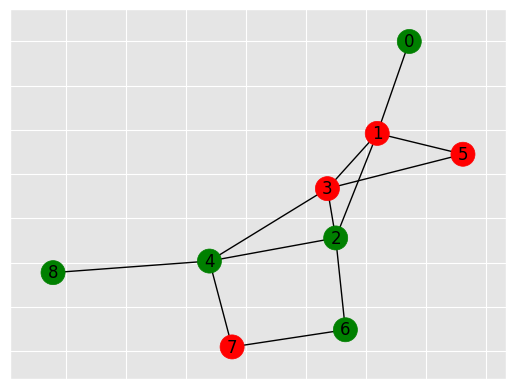

In [41]:
# Filling labels for graph G

def fill_labels(G):
    for i in range(len(G.nodes)):
        if i%2 ==0:
            G.nodes[i]['label'] = 'A'
        else:
            G.nodes[i]['label'] = 'B'
from networkx.algorithms import node_classification
G = nx.Graph()
G = nx.read_edgelist('./data/edge_list.txt')
mapping = {}
for i in G.nodes:
    mapping[f"{i}"] = int(i)
G = nx.relabel_nodes(G, mapping)

fill_labels(G)
#plt.show()
#nx.draw(G, with_labels=True)
draw_graph(G)

#### Setting unlabeled nodes by using unlabel_set

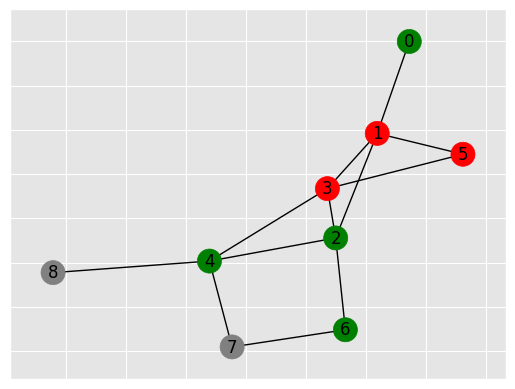

In [42]:
# Lets hide labels of nodes 7 and 8
unlabel_set = [7,8]
for n in unlabel_set:
   G.nodes[n]['label'] = ''
draw_graph(G)

#### Predict label of nodes

In [43]:
predicted = node_classification.local_and_global_consistency(G)
predicted

['A', 'B', 'A', 'A', 'B', 'A', 'A', 'A', 'A']

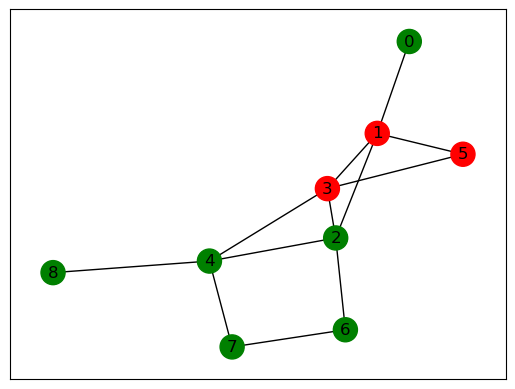

In [11]:
for i in range(len(G.nodes)):
    if G.nodes[i]['label']=='':
        G.nodes[i]['label']= predicted[i]

draw_graph(G)

#### Testing Karate graph

In [44]:
#Draw graph with different labeled nodes, different colours
def draw_graph_1(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['club']
        col = 0
        if c=='Officer':
            clubs.append('green')
        elif c =='Mr. Hi':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph
    

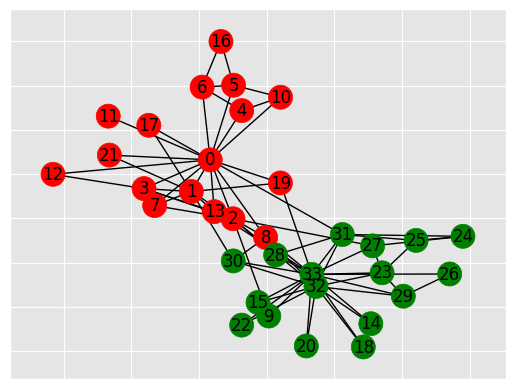

In [45]:
#visualize karate graph
G = nx.karate_club_graph()  # load data
draw_graph_1(G)

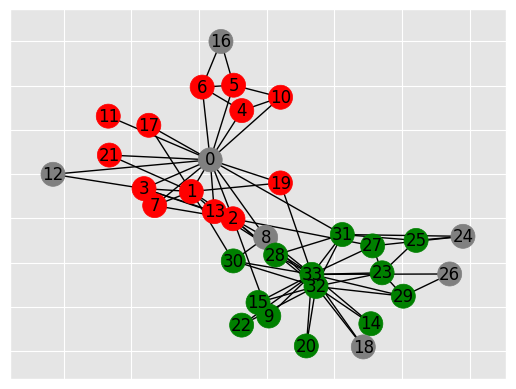

In [46]:
#Lets hide several node labels
unlabel_set = [0,12,16,18,26,24,8]


for n in unlabel_set:
    G.nodes[n]['club'] = ''
draw_graph_1(G)

In [47]:
# 
#local_and_global_consistency(G, alpha=0.99, max_iter=30, label_name='label')

predicted = node_classification.local_and_global_consistency(G,label_name='club')


for i in range(len(G.nodes)):
    if G.nodes[i]['club']=='':
        G.nodes[i]['club']= predicted[i]




In [48]:
#Draw graph with different labeled nodes, different colours
def draw_graph_1(G):
    clubs = []  # list to populate with labels
    for n in G.nodes:
        c = G.nodes[n]['club']
        col = 0
        if c=='Officer':
            clubs.append('green')
        elif c =='Mr. Hi':
            clubs.append('red')
        else:
            clubs.append('gray')
    pos = nx.spring_layout(G, seed=42) # To be able to recreate the graph layout
    nx.draw_networkx(G, pos=pos, node_color = clubs) # Plot the graph
    

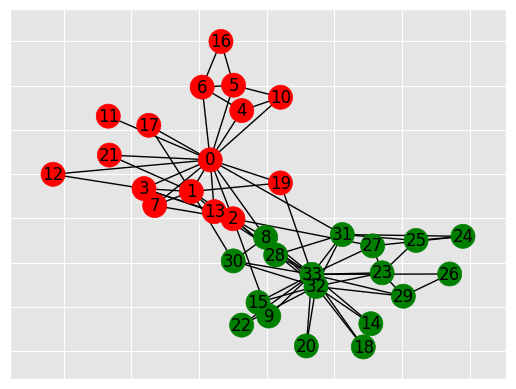

In [49]:
draw_graph_1(G)

# 5. Label propagation 

At each step of the process, each vertex updates its label to a new one which
corresponds to the most frequent label among its neighbours.

In [51]:
# Import libraries
import pandas as pd #For reading dataset files
import networkx as nx #For network creation/analysis
from networkx.algorithms import community
import community as community_louvain
import matplotlib.pyplot as plt #For plotting graphs
%matplotlib inline

#### Load karate graph from library

In [52]:
G = nx.karate_club_graph()

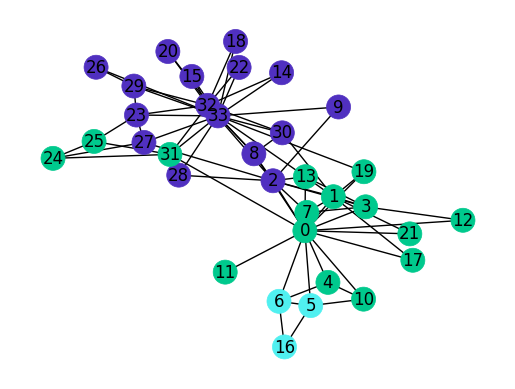

In [53]:
colors = ["#00C98D", "#5030C0", "#50F0F0"]
pos = nx.spring_layout(G)
lst_m = community.label_propagation_communities(G)
color_map_b = {}
keys = G.nodes()
values = "black"
for i in keys:
        color_map_b[i] = values
counter = 0
for c in lst_m:
    for n in c:
        color_map_b[n] = colors[counter]
    counter = counter + 1
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_nodes(G, pos, node_color=dict(color_map_b).values())
nx.draw_networkx_labels(G, pos)
plt.axis("off")
plt.show()

# 6. Node-Based Feature Propagation with SVM Classifier

## 6.1 Node degree as features

Accuracy: 0.2857142857142857


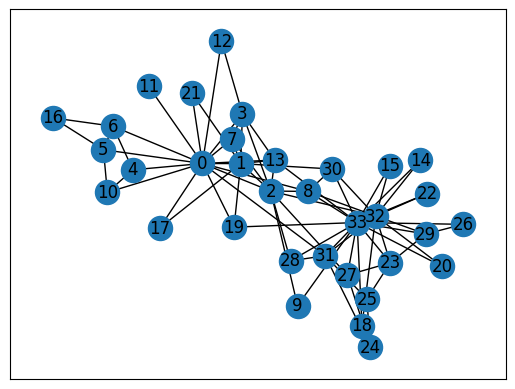

In [7]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx

# Load Zachary's Karate Club network
G = nx.karate_club_graph()
nx.draw_networkx(G, with_labels = True)

# Generate features for each node (in this case, we'll use node degrees as features)
node_features = {node: [deg] for node, deg in G.degree}

# Assign labels to nodes
node_labels = {node: G.nodes[node]['club'] == 'Officer' for node in G.nodes}

# Function for information propagation on the graph
def propagate_information(G, node_features, num_iterations=3):
    propagated_features = node_features.copy()
    for _ in range(num_iterations):
        new_features = {}
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            neighbor_features = [propagated_features[n] for n in neighbors]
            new_features[node] = np.mean(neighbor_features, axis=0)
        propagated_features = new_features
    return propagated_features

# Propagate information on the graph
propagated_features = propagate_information(G, node_features)

# Prepare data for classification
X = np.array([propagated_features[node] for node in G.nodes])
y = np.array([node_labels[node] for node in G.nodes])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


## 6.2 Node centrality as features

Accuracy: 0.42857142857142855


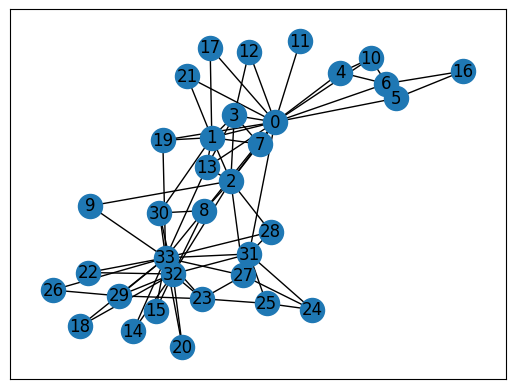

In [36]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx

# Load Zachary's Karate Club network
G = nx.karate_club_graph()
nx.draw_networkx(G, with_labels = True)

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Update node_features dictionary with centrality measures
for node in G.nodes:
    node_features[node] = [degree_centrality[node], closeness_centrality[node], betweenness_centrality[node]]

# Assign labels to nodes
node_labels = {node: G.nodes[node]['club'] == 'Officer' for node in G.nodes}

# Function for information propagation on the graph
def propagate_information(G, node_features, num_iterations=3):
    propagated_features = node_features.copy()
    for _ in range(num_iterations):
        new_features = {}
        for node in G.nodes:
            neighbors = list(G.neighbors(node))
            neighbor_features = [propagated_features[n] for n in neighbors]
            new_features[node] = np.mean(neighbor_features, axis=0)
        propagated_features = new_features
    return propagated_features

# Propagate information on the graph
propagated_features = propagate_information(G, node_features)

# Prepare data for classification
X = np.array([propagated_features[node] for node in G.nodes])
y = np.array([node_labels[node] for node in G.nodes])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train SVM classifier
classifier = svm.SVC(kernel='linear')
classifier.fit(X_train, y_train)

# Predict labels for test set
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# 7. Node Representations with Weisfeiler-Lehman Kernel Features and Initial Node Attributes

In [37]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import networkx as nx

# Load the Karate Club dataset
G = nx.karate_club_graph()

# Convert the graph to a numpy array (adjacency matrix)
X_graph = nx.to_numpy_array(G)

# Generate labels (assuming two classes: 'club' and 'not club')
y = np.array([1 if G.nodes[i]['club'] == 'Mr. Hi' else 0 for i in G.nodes()])

# Initial node features (assuming no initial features, just identity matrix)
X_initial = np.eye(len(G.nodes()))  # Assuming each node has its own identity as initial features

# Concatenate WL kernel features with initial features
X_concatenated = np.concatenate((X_graph, X_initial), axis=1)

# Reduce dimensionality using PCA
pca = PCA(n_components=10)  # Reduce to 10 dimensions
X_reduced = pca.fit_transform(X_concatenated)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Initialize SVM classifier
svm = SVC()

# Train the classifier
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8571428571428571
